In [2]:
from __future__ import absolute_import, division, print_function
from builtins import *  # @UnusedWildImport

from mcculw import ul
from mcculw.enums import DigitalIODirection, ScanOptions, Status, FunctionType, BoardInfo
from mcculw.device_info import DaqDeviceInfo
import pyvisa as visa 
from ctypes import cast, POINTER, c_ushort

ModuleNotFoundError: No module named 'mcculw'

In [4]:
from math import pi, sin, exp
from time import *
from scipy import signal      

import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd

In [2]:
try:
    from console_examples_util import config_first_detected_device
except ImportError:
    from .console_examples_util import config_first_detected_device

In [13]:
#calculate rate and insert cycle time of scan data
#initial function for start up value set to zero in form of dataframe
def Data_initial():
    global dataframe_data, points_per_channel, ao_range, board_num, low_chan, high_chan, num_chans, memhandle, ao_info, total_count, rate
    
    #Initail calculation data
    ####################################################
    rate = 500000
    points_per_channel = int(rate*times)
    ####################################################
    
    #Board initail info
    ####################################################
    dev_id_list = []
    board_num = 0
    memhandle = None
    config_first_detected_device(board_num, dev_id_list)
    daq_dev_info = DaqDeviceInfo(board_num)
    ao_info = daq_dev_info.get_ao_info()
    ao_range = ao_info.supported_ranges[0]
    low_chan = 0
    high_chan = min(3, ao_info.num_chans - 1)
    num_chans = high_chan - low_chan + 1
    total_count = points_per_channel * num_chans
    memhandle = ul.win_buf_alloc(total_count)
    ####################################################
    
    dataframe_data = pd.DataFrame({'AO0':np.zeros(points_per_channel), 'AO1':np.zeros(points_per_channel), 
                                   'AO2':np.zeros(points_per_channel), 'AO3':np.zeros(points_per_channel)})

In [6]:
#linear ramping output data
#we have change data in range of dataframe.
#insert dataframe in subset of dataframe form.
#such as df.subset_of_dataframe


def Set(end_time, next_value, dataframe_data_set):
    global start_time, start_value
    start_point = round((points_per_channel*(start_time))/times)
    end_point = round((points_per_channel*(end_time))/times)
    data_point=-start_point+end_point
    
    if start_point != 0:
        start_value = round(dataframe_data_set[start_point-1])
    else:
        start_value = 0

    start_time = end_time
    # print(start_point, end_point, start_value, next_value,data_point)
    if start_value == next_value:
        data_ramp = next_value*np.ones(data_point)
    else :
        data_ramp = np.linspace(start_value, next_value, data_point)
    dataframe_data_set[start_point:end_point]=data_ramp
    return dataframe_data , start_time , start_value

In [7]:
#control the output data by using ramp function or another function
def Analog_output_0(): #mot-loading
    global start_time, start_value
    start_time = 0.0
    Set(mot_start_time,0,dataframe_data.AO0)
    Set(mot_start_time+short_step_time,TTL_val,dataframe_data.AO0)
    Set(mot_end_time,TTL_val,dataframe_data.AO0)
    Set(mot_end_time+short_step_time,0,dataframe_data.AO0)
    return dataframe_data.AO0
def Analog_output_1(): #imaging beam
    global start_time, start_value
    start_time = 0.0
    for i in range(num_img):
        Set(img_start_time +i*img_wait ,0,dataframe_data.AO1)
        Set(img_start_time+short_step_time+i*img_wait,TTL_val,dataframe_data.AO1)
        Set(img_end_time+i*img_wait,TTL_val,dataframe_data.AO1)
        Set(img_end_time+short_step_time+i*img_wait,0,dataframe_data.AO1)
    return dataframe_data.AO1
def Analog_output_2(): #camera
    global start_time, start_value
    start_time = 0.0
    for i in range(num_img):
        Set(img_start_time +i*img_wait ,0,dataframe_data.AO2)
        Set(img_start_time+short_step_time+i*img_wait,TTL_val,dataframe_data.AO2)
        Set(img_end_time+i*img_wait,TTL_val,dataframe_data.AO2)
        Set(img_end_time+short_step_time+i*img_wait,0,dataframe_data.AO2)
    return dataframe_data.AO2

def Analog_output_3():
    global start_time, start_value
    start_time = 0.0
    Set(n,5,dataframe_data.AO3)
    Set(m,3,dataframe_data.AO3)
    # plt.plot(dataframe_data.AO3,color='purple')
    return dataframe_data.AO3



In [8]:
#convert every value in dataframe to 1D numpy array
def Array_output_data():
    array = np.transpose(np.array([Analog_output_0(),Analog_output_1(),Analog_output_2(),Analog_output_3()])).flatten()
    return array

In [7]:
def save_data():
    data_index = 0
    ctypes_array = cast(memhandle, POINTER(c_ushort))
    print('---------------Start saving data---------------')
    for channel_num in range(num_chans):
        for point_num in range(points_per_channel):
            value = dataframe_array[data_index]
            raw_value = ul.from_eng_units(board_num, ao_range, value)
            ctypes_array[data_index] = raw_value
            data_index += 1
        print('Saving', ((channel_num+1)/4)*100 ,'% of data')
    print('---------------Saving data complete---------------')
    return

In [8]:
def scan(scan_round):
    for i in range(scan_round):
        ul.a_out_scan(board_num, low_chan, high_chan, total_count, rate, ao_range, memhandle, ScanOptions.BACKGROUND)
        print('Waiting for scan.', end='')
        status = Status.RUNNING
        while status != Status.IDLE:
            print('.', end='')
            # Slow down the status check so as not to flood the CPU
            sleep(1)
            status, _, _ = ul.get_status(board_num, FunctionType.AOFUNCTION)
        print('')
        print('Period',i+1,'complete')
        sleep(1)

In [9]:
def Sequence_setting():
    global mot_start_time, short_step_time
    short_step_time = 0.000004
    TTL_val=4
    start_time=0
    start_value=0
    mot_start_time = 0.25
    mot_dur=10
    mot_end_time = mot_start_time + mot_dur
    tof_time= 0.01
    img_start_time = mot_end_time + tof_time
    img_dur = 0.0001
    img_end_time = img_start_time +img_dur
    img_wait=0.25
    # num_img=int(mot_end_time/img_wait+1)                     #For capture mot from start point to saturated of MOT
    num_img=2#int(mot_end_time/img_wait+1)
    times = mot_dur+1

In [43]:
start_time=0
start_value=0
mot_start_time = 0.25
mot_dur=10
mot_end_time = mot_start_time+mot_dur
tof_time= 0.001
img_start_time = mot_end_time+tof_time
img_dur = 0.0002
img_end_time = img_start_time +img_dur
img_wait=0.25
num_img=2#int(mot_end_time/img_wait+1)
times = mot_dur+1
short_step_time = 0.000004
TTL_val=4

In [44]:
rate = 500000
points_per_channel = int(rate*times)
dataframe_data = pd.DataFrame({'AO0':np.zeros(points_per_channel), 'AO1':np.zeros(points_per_channel), 
                                   'AO2':np.zeros(points_per_channel), 'AO3':np.zeros(points_per_channel)})

Set(mot_start_time,0,dataframe_data.AO0)
Set(mot_start_time+short_step_time,TTL_val,dataframe_data.AO0)
Set(mot_end_time,TTL_val,dataframe_data.AO0)
Set(mot_end_time+short_step_time,0,dataframe_data.AO0)
for i in range(num_img):
    Set(img_start_time +i*img_wait ,0,dataframe_data.AO1)
    Set(img_start_time+short_step_time+i*img_wait,TTL_val,dataframe_data.AO1)
    Set(img_end_time+i*img_wait,TTL_val,dataframe_data.AO1)
    Set(img_end_time+short_step_time+i*img_wait,0,dataframe_data.AO1)

(5120000.0, 5130000.0)

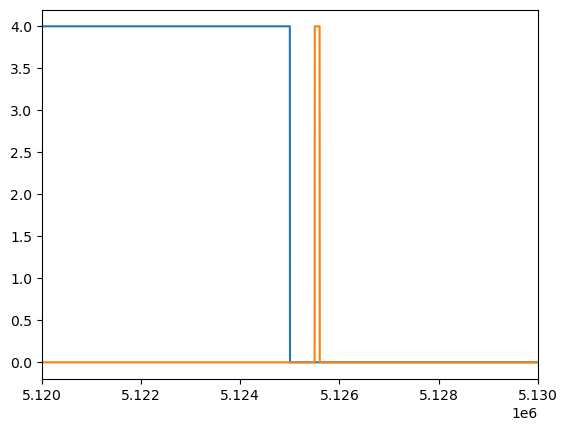

In [45]:
plt.plot(dataframe_data['AO0'])
plt.plot(dataframe_data['AO1'])
plt.xlim(5120000,5130000)

In [113]:
Data_initial()
dataframe_array = Array_output_data()
save_data()
scan(5)

Found 1 DAQ device(s):
  USB-1208HS-4AO (206B1F2) - Device ID = 198
---------------Start saving data---------------
Saving 25.0 % of data
Saving 50.0 % of data
Saving 75.0 % of data
Saving 100.0 % of data
---------------Saving data complete---------------
Waiting for scan.............
Period 1 complete
Waiting for scan.............
Period 2 complete
Waiting for scan.............
Period 3 complete
Waiting for scan.............
Period 4 complete
Waiting for scan.............
Period 5 complete
